# Introduction

We will implement the neural network architecture used in the proof of the theorem 2 from the article " _Error Bounds For approximations With Deep ReLU Networks_ ". 
1. A detailed reminder of the method used to build the neural network
2. The actual implementation in python of the neural network
3. The analysis of the neural network architecture throw different target function to approximate

# Libraries

In [1]:
# Keras

from keras.layers import Input, Dense, Activation, concatenate
from keras.models import Sequential, Model
from keras.activations import relu, linear
from keras.initializers import Constant, ones, zeros
from keras.utils import plot_model


Using TensorFlow backend.


In [2]:
# Version of TensorFlow used

import tensorflow as tf
print(tf.__version__)

2.1.0


<font color="red">
If you launch this notebook with an other version of TensorFlow, this could lead to several errors

In [3]:
# other useful libraries

%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np


# Target function

We need a 1-Lipschitz function $\iff$ A function with a derivative (not necessarily continuous) $\leq 1$.
<br> We don't want a trivial function so we create one from $x^2 sin(\frac1 x)$ (which is 1-Lipschitz).
<br> $target(x) = x^2 sin(\frac1 x) \mathbb{1}_{x \leq \frac 1 2} + (1-x) ^2 sin(\frac{1}{1-x} ) \mathbb{1}_{x > \frac 1 2}$ 

In [4]:
def target_aux(x):
    return x**2*np.sin(1/(x+1e-10))

def target(x):
    return target_aux(x) * (x <= 1/2) + target_aux(1-x) * (x > 1/2)

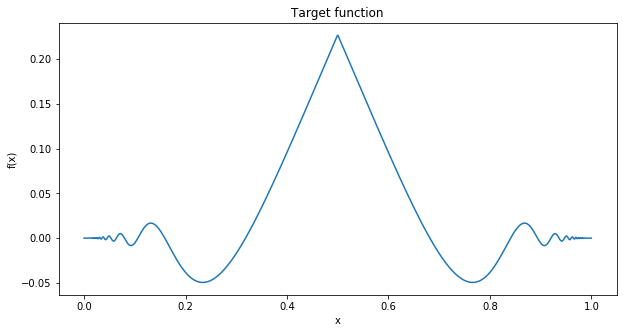

# Implementation of the adaptative neural network

## Reminder of the method

As described in the article, the idea is to approximate a function $f$ by $\tilde f$ where $\tilde f = \tilde f_1 + \tilde f_2$ :
- $\tilde f_1$ is piecewise linear interpolation of $f$
- $\tilde f_2$ is an approximation of the residu $f - \tilde f_1$


#### Construction of $\tilde f_1$

Let $\big(t_i\big)_{i=0..T}$ with $t_i = \frac{i}{T}$ be the breakpoints of the interpolation. We can easily build a neural network corresponding to this interpolation, which we can deduce from this expression:
$$\tilde f_1(x) = \sum_{i=0}^{T-1} w_i \sigma\left(x - t_i\right) \hspace{1cm} \text{with} \ \sigma \ \text{the ReLu activation function}$$

To compute the weights $(w_i)_{i=0..T-1}$ one can notice that the weight $w_i$ must compensate the previous weights to have just the right slope between the two points $t_i$ and $t_{i+1}$. Formally:
$$w_i = \frac{f(t_{i+1}) - f(t_i)}{t_{i+1}-t_i} - \sum_{k=0}^{i-1} w_k$$

#### Construction of $\tilde f_2$

The idea is simple: for each interval $I_t = \left[\frac{t}{T}, \frac{t+1}{T}\right[$ we approximate $f - \tilde f_1$ by the best piecewise linear function (potentially different for each interval) from a finite set of such functions.

Now, let's construct the approximation $\tilde f_2$. To illustrate the construction, consider the following graphs  

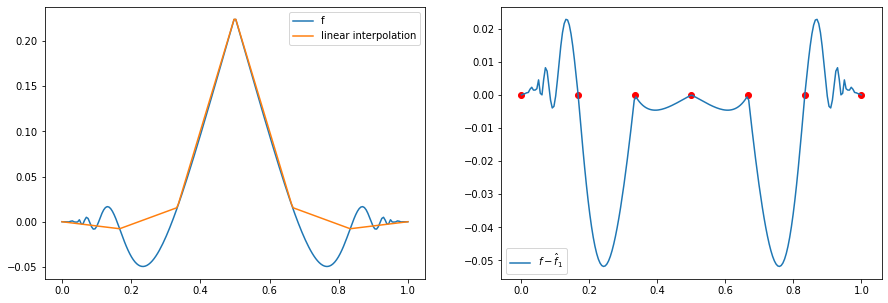

Let's focus on one interval $I_t$ rescaled over $[0, 1]$ (plot of $f_2\left(\frac{t+y}{T}\right)$ with $y \in [0, 1]$). We consider here the interval $I_1$.

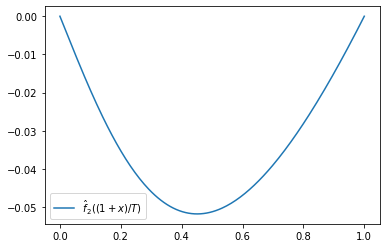

However, we will not seek the piecewise linear approximation right now. Indeed, it will not generalize well as $\sup_{y \in [0, 1]} \big| f_2\left(\frac{t+y}{T}\right) \big|$ tends to $0$ when $T$ increases. We need to approximate a rescaled version of $\tilde f_1\left(\frac{t+\cdot}{T}\right)$. A good choice is $T f_2\left(\frac{t+\cdot}{T}\right)$ as it is 2-Lipschitz.

__proof (1)__

We know that $f$ is 1-Lipschitz, so its piecewise linear interpolation as well. $\forall x, x' \in [0, 1]$ we have :

$\big|f_2\left(\frac{t+x}{T}\right) - f_2\left(\frac{t+x'}{T}\right) \big| =
\big| f\left(\frac{t+x}{T}\right) - f\left(\frac{t+x'}{T}\right) + \tilde f_1\left(\frac{t+x}{T}\right) - \tilde f_1\left(\frac{t+x'}{T}\right) \big|$

$\big|f_2\left(\frac{t+x}{T}\right) - f_2\left(\frac{t+x'}{T}\right) \big| \leq
\big| f\left(\frac{t+x}{T}\right) - f\left(\frac{t+x'}{T}\right) \big| +
\big|\tilde f_1\left(\frac{t+x}{T}\right) - \tilde f_1\left(\frac{t+x'}{T}\right) \big|$

$\big|f_2\left(\frac{t+x}{T}\right) - f_2\left(\frac{t+x'}{T}\right) \big| \leq
\big| \frac{t+x}{T} - \frac{t+x'}{T} \big| + \big| \frac{t+x}{T} - \frac{t+x'}{T} \big| =
2 \big| \frac{t+x}{T} - \frac{t+x'}{T} \big|$

$\big|f_2\left(\frac{t+x}{T}\right) - f_2\left(\frac{t+x'}{T}\right) \big| \leq 
\frac{2}{T} |x - x'|$

__end__


Thus, for every $T$, the variations of $T \tilde f_1\left(\frac{t+\cdot}{T}\right)$ (which will be called $g_t$) have the same magnitude. It allows us to choose a single finite set $\Gamma$ of piecewise linear functions to approximate every $g_t$, whether $T$ is high or not. Let's find such a set.

A natural property for $\Gamma$ would be piecewise functions with equally separated breakpoints $\left(\frac{r}{m}\right)_{r=0..m}$. However, the functions $g_t$ are 2-Lipschitz so we can restrict $\Gamma$ (which will be noted $\Gamma_m$) with the following property over the breakpoints : $\forall \gamma \in \Gamma_m$ $\big| \gamma\left(\frac{r+1}{m}\right) - \gamma\left(\frac{r}{m}\right) \big| \leq 2 \frac{1}{m}$. As we mentioned at the beginning, we seek a finite set, and a natural way to do so would be to restrict the possible values at each breakpoint (like a sampling). Therefore, to remain consistent with the previous property we impose on $\Gamma_m$ another restriction:

$$\forall \gamma \in \Gamma_m, \ \ \gamma\left(\frac{r+1}{m}\right) - \gamma\left(\frac{r}{m}\right) \in \left\{-\frac{2}{m}, 0, \frac{2}{m}\right\} \ r = 0, ..., m-1$$

Then, to get a finite set we need to fix one value. To do so, we simply need to notice that $g_t(0)=g_t(1)=0$ because $\tilde f_1$ is an interpolation. So the last property will be:

$$\forall \gamma \in \Gamma_m, \ \ \gamma(0) = \gamma(1) = 1$$

All these properties define a finite set of piecewise linear functions not larger than $3^m$. To better understand what kind of set $\Gamma_m$ is, let's see the following illustrations.

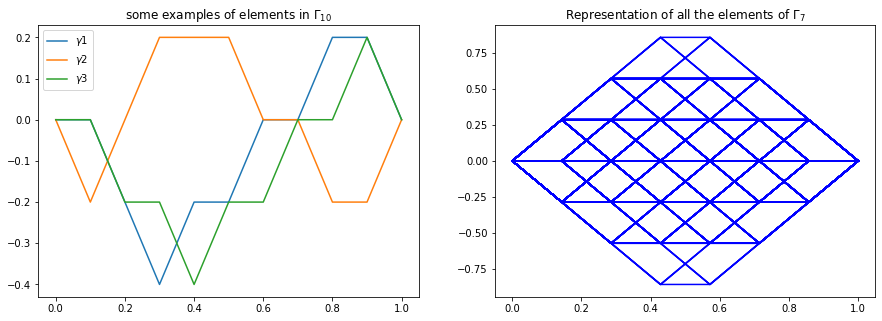

Let's go back to the approximation of $g_t$. We show below $g_1$ and its best approximation from $\Gamma_{10}$.

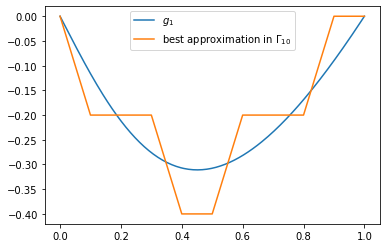

The question we need to answer now is: how do we choose the best approximation from $\Gamma_m$? The elements of $\Gamma_m$ have restricted values which are all multiples of $\frac{2}{m}$. Thus, the best approximation of $g_t$ is the element $\gamma \in \Gamma_m$ which has, for each breakpoint $\frac{r}{m}$, the multiple of $\frac{2}{m}$ closest to $g_t\left(\frac{r}{m}\right)$: $\gamma\left(\frac{r}{m}\right) = \frac{2}{m} \text{closestInteger}\left(g_t\left(\frac{r}{m}\right)\big/\frac{2}{m}\right)$

Note: This expression is slightly different from the one found in the article, which uses $\lfloor \cdot \rfloor$ instead of the closest integer. Even if it doesn't change anything theoretically, in practice the approximations we get are better. $\lfloor \cdot \rfloor$ is used in the article for its well-known properties useful to bound the error in each interval.

__To sum up__

For each $t \in \{0, ..., T-1\}$ we approximate $g_t = T f_2\left(\frac{t + \cdot}{T}\right)$ with an element $\gamma_t \in \Gamma_m$. So we get our approximation for $f_2$:

$$\forall x \in I_t, \ \ \tilde f_2(x) = \frac{1}{T} \gamma_t(T x - t)$$

## About the hyper-parameters

The article gives the upper bound for the approximation error $\sup\limits_{x \in [0, 1]} | f(x) - \tilde f(x) | \leq \frac{2}{T m}$. In particular, if we want an approximation which has an approximation error not greater than $\varepsilon > 0$ then we must choose $T$ and $m$ such that $\frac{2}{T m} \leq \varepsilon$. We also must take into consideration the size of the neural network related to this approximation, a size which depends on $T$ and $m$.

The point of this approximation is that it can be implemented as a neural network with an asymptotical number of weights (as $\varepsilon$ decreases) surprisingly small. This will be discussed in the presentation of the second implementation. 

## Naive architecture

From the description above, we can try to build a neural network corresponding to $\tilde f$. We have seen how to do that for $\tilde f_1$. We can also do that for $\tilde f_2$ by noticing :
$$\tilde f_2(x) = \sum_{t=0}^{T-1} \frac{1}{T} \gamma_t(\rho(T x -t)) \hspace{1cm} \text{with} \ 
\rho(x) = \left\{
\begin{array}{ll}
      x & x \in [0, 1[ \\
      0 & x \not \in [0, 1[ \\
\end{array} 
\right.
$$

Besides, $\gamma_t$ is a piecewise linear function so it can be easily implemented with a neural network (as we saw for the construction of $\tilde f_1$). We can now build the neural network.
- __First layer__: one unit corresponding to the input $x \in [0, 1]$
- __Second layer__: $T$ units $Q^{(2)}_t$ computing $\rho(T x - t)$
- __Third layer__: $m \times T$ units $Q^{(3)}_{t,r}$ computing for each $t$ the decomposition of $\gamma_t$ as a piecewise linear function
- __Fourth layer__: $T$ units $Q^{(4)}_t$ computing for each $t$ the corresponding $\gamma_t(\rho(T x - t))$
- __Fifth layer__: one unit computing $\tilde f_2(x) = \sum_{t=0}^{T-1} \frac{1}{T} \gamma_t(\rho(T x -t))$

Which produces a neural network with that kind of architecture:

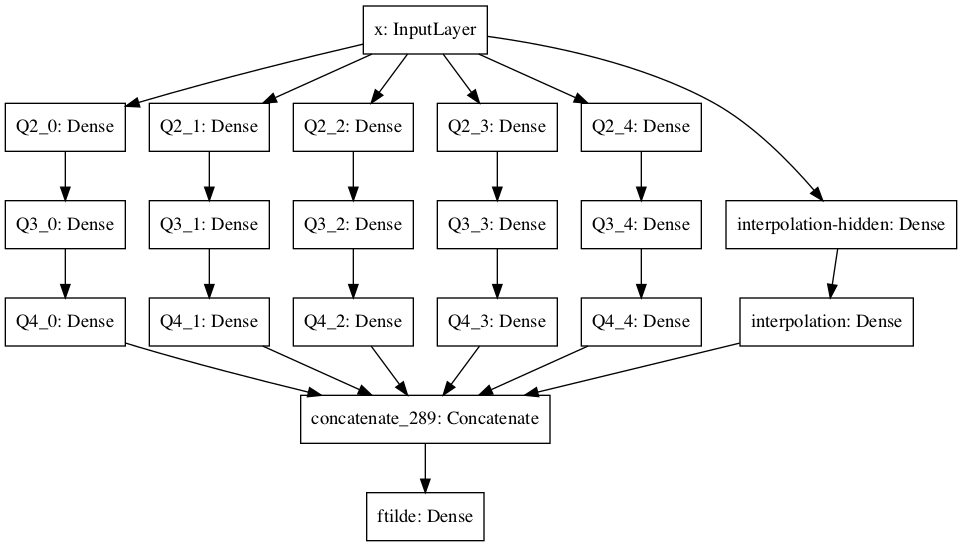

### Complexity of the naive architecture

First, we compute the actual complexity of the neural networks produced:
- The part of the neural network computing $\tilde f_1$ has $\Theta(T)$ weights
- The part of the neural network computing $\tilde f_2$ has $\Theta(mT)$ weights
    - At the __second layer__ it has $\Theta(T)$ weights
    - The __third layer__ adds $\Theta(mT)$ weights
    - The __fourth layer__ adds $\Theta(T)$ weights
    - The __fifth layer__ adds $\Theta(T)$ weights
    
In the end, this implementation produces neural networks with a complexity of $\Theta(mT)$ (precisely $7T + 3mT + c$ with $c$ a constant). It highlights the fact that this architecture is not exactly the same as the one described in the proof of the theorem 2, which has a complexity of $\mathcal{O}(T + m 3^m)$. Therefore, the upper bound for the complexity $C_{\varepsilon}$ as a function of the error bound $\varepsilon$ is weaker. Indeed, we saw that $\frac{2}{T m} \leq \varepsilon$ ensures that the error bound is respected so we can expect $C_{\varepsilon} \geq \frac{c}{\varepsilon}$ for some constant $c$ (The article gives $C_{\varepsilon} \leq \frac{c}{\varepsilon \log 1/\varepsilon}$).

Nevertheless, the output is exactly the same and the implementation is simpler. 

### Implementation of the naive architecture in python

As we saw, the method relies a lot on a piecewise linear function. Therefore, we first code some functions to deal with this kind of function in the context of neural networks.

In [5]:
# Input : breakpoints of the piecewise function
#         values of the piecewise function at the breakpoints
#
# Output : weights of the middle layer of the corresponding neural network

def weights_piecewise_linear(points, values):
    size = len(points)-1
    
    w = np.zeros(size)
    for i in range(size):
        w[i] = (values[i+1] - values[i])/(points[i+1] - points[i]) - np.sum(w)
    
    return w


In [6]:
# Input : breakpoints of the piecewise function
#         values of the piecewise function at the breakpoints
#         input of the neural network
#         name of the last layer
#         name of the middle layer
#
# Output : the corresponding neural network

def piecewise_linear(points, values, x, name="interpolation", name_hidden="interpolation-hidden"):
    T = len(points)-1
    
    # The biases corresponding to the breakpoints
    breakpoints = -points[:-1]
    
    # The weights corresponding to the slope of the piecewise linear functions
    slopes = weights_piecewise_linear(points, values)
    
    # Build the corresponding network
    y = Dense(T, activation=relu, 
              kernel_initializer=ones(), bias_initializer=Constant(breakpoints),
              name=name_hidden)(x)
    
    y = Dense(1, activation=linear, 
              kernel_initializer=Constant(slopes), bias_initializer=Constant(values[0]), 
              name=name)(y)
    
    return y

In [7]:
# Implementation of the rho activation function

from keras import backend as K

def rho_activation(x):
    return K.relu(x) - K.relu(x - 1) - 0.5*(K.sign(x - 1) + 1)


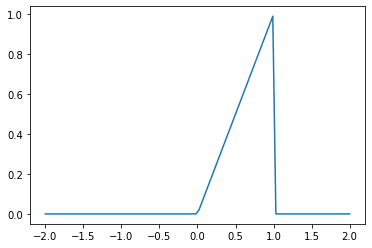

In [8]:
# Visualisation of the rho activation function

x = np.linspace(-2, 2, 100)
xt = K.variable(x)
yt = rho_activation(xt)

plt.plot(x, np.array(yt))
plt.show()

In [9]:
# Naive implementation of the approximation as a neural network

# Inputs : target function f
#          hyper-parameter T
#          hyper-parameter m
#
# Output : ftilde as a neural network

def adaptive_network_naive(f, T, m):
    
    # First layer - the input
    x = Input(shape=(1,), name="x")
    
    # - - - - - - - - - - - - - - - - - - - - - -
    # - - - piece-wise linear interpolation - - -
    # - - - - - - - - - - - - - - - - - - - - - -
    
    points = np.arange(T+1)/T
    values = f(points)
    f1tilde = piecewise_linear(points, values, x)
    
    # Useful to compute some values later
    model_f1tilde = Model(x, f1tilde)
    
    # - - - - - - - - - - - - - - -
    # - - - residual function - - -
    # - - - - - - - - - - - - - - -
    
    # Breakpoints of the gamma_t functions
    points = np.arange(m+1)/m
    
    # Compute g_t
    def g(t, y):
        X = (t+y)/T
        return T*(f(X) - model_f1tilde.predict(np.array([X])).flatten()[0])
    
    # Build the network for f2tilde
    f2tilde = []
    for t in range(T):
        # Second layer - rho(T x - t)
        f2tilde.append(Dense(1, activation=rho_activation, 
                             kernel_initializer=Constant(T), bias_initializer=Constant(-t),
                             name="Q2_"+str(t))(x))
        
        # Compute the values of the gamma_t functions
        values = np.zeros(m+1)
        for r in range(m+1):
            if r == 0 or r == m:
                values[r] = 0
            else:
                values[r] = 2/m * np.rint(g(t, r/m)*m/2)
        
        # Third & fourth layer - gamma_t(T x - t)
        f2tilde[t] = piecewise_linear(points, values, f2tilde[t], "Q4_"+str(t), "Q3_"+str(t))
    
    # - - - - - - - - - - - - - -
    # - - - combined  model - - -
    # - - - - - - - - - - - - - -
    
    # The weights corresponding to the merge of f1tilde and f2tilde
    merge_weights = np.array([1] + T*[1/T])
    
    ftilde = concatenate([f1tilde] + f2tilde)
    ftilde = Dense(1, activation=linear, kernel_initializer=Constant(merge_weights), name="ftilde")(ftilde)
        
    return Model(x, ftilde)

m = 4
T = 10
C = 193


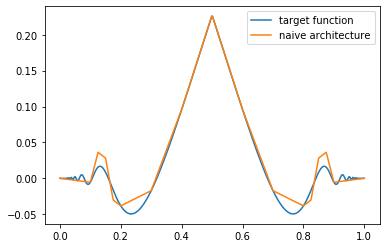

In [10]:
# Let's test the algorithm

# Define the hyper-parameters
m = 4
T = 10
print("m =", m)
print("T =", T)

# Create the corresponding neural network
ftilde = adaptive_network_naive(target, T, m)
print("C =", ftilde.count_params())


# Plot the graph of the target function and the approximation
x = np.linspace(0, 1, 400)
y = ftilde.predict(x)

plt.plot(x, target(x), label="target function")
plt.plot(x, y, label="naive architecture")
plt.legend()
plt.show()

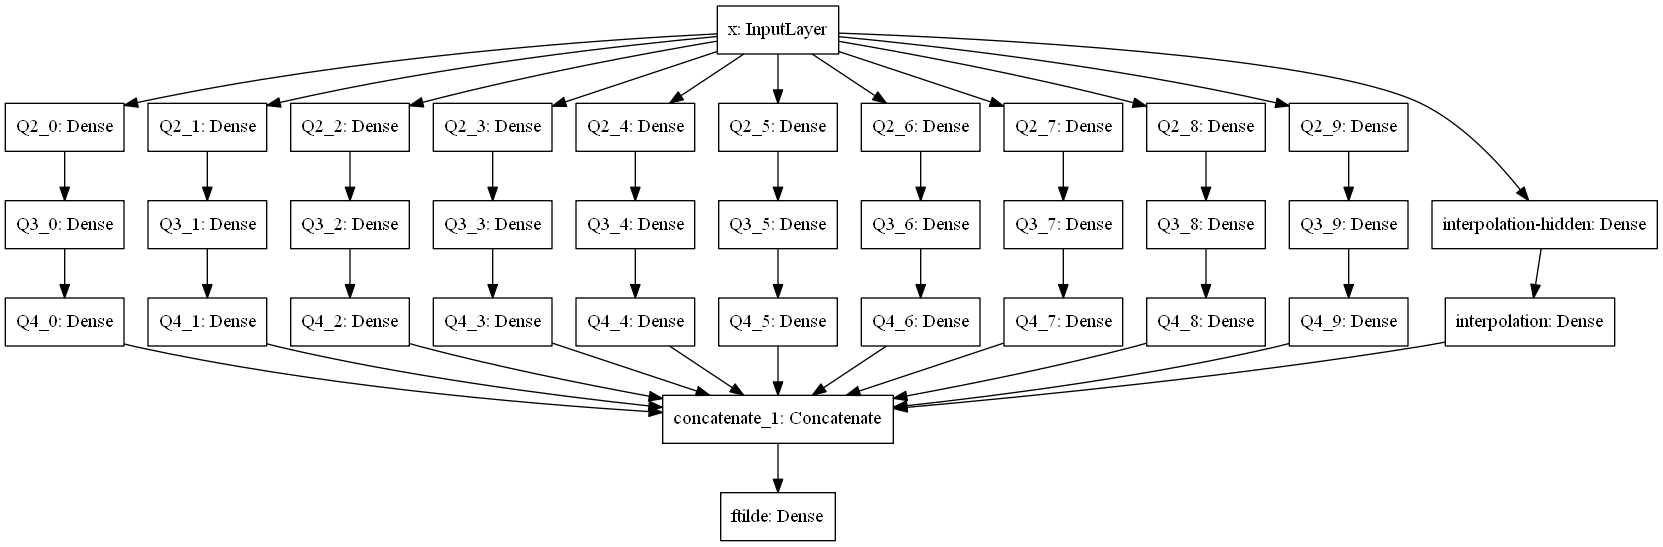

In [11]:
# Visualize the neural network

plot_model(ftilde, to_file='model_naive.png' )


In [12]:
# Estimate the error of the approximation

xtest = np.random.uniform(0, 1, 1000)
ytest = target(xtest)
yapprox = ftilde.predict(xtest).flatten()

# Compute the error
err = np.mean(np.abs(ytest - yapprox))

# Compare it to the theoretical upper bound of the error
print("Upper bound : 2/mT =", 2/m/T)
print("error of approximation :", err)


Upper bound : 2/mT = 0.05
error of approximation : 0.005873567838756971


## Optimal architecture

Now, we are going to discuss the implementation of the approximation exactly as it is described in the article. To optimize the neural network, we will use the fact that, the same element $\gamma \in \Gamma_m$ can be used in several intervals $I_t$. Here is a little reminder:

$$\forall t \in \{0, ..., T-1\}, \ \ \exists \gamma_t \in \Gamma_m, \ \ \forall x \in I_t, \ \ \tilde f_2(x) = \frac{1}{T} \gamma_t(T x - t)$$

This time we will not directly sum over $t$ but over all the elements in $\Gamma_m$ like this:

$$\tilde f_2(x) = \sum_{\gamma \in \Gamma_m} \frac{1}{T} \gamma\left( \sum_{\substack{t=0\\ \gamma_t = \gamma}}^{T-1} \rho(T x - t) \right)$$

Note: If we fix $x \in I_t$ we get the same expression as above. Also, in the first sum, the terms corresponding to unused $\gamma \in \Gamma_m$ vanish. 

Every $\gamma \in \Gamma_m$ is a piecewise linear function, so they can be implemented as a neural network (as we saw for the construction of $\tilde f_1$) like this:

$$\gamma(x) = \sum_{r = 0}^{m-1} c_{\gamma, r} \sigma\left(x - \frac{r}{m}\right)$$

which gives us the following expression for $\tilde f_2$:

$$\tilde f_2(x) = \sum_{\gamma \in \Gamma_m} \sum_{r = 0}^{m-1} \frac{c_{\gamma, r}}{T} \sigma\left( \sum_{\substack{t=0\\ \gamma_t = \gamma}}^{T-1} \rho(T x - t) - \frac{r}{m} \right)$$

From this expression we can deduce the following architecture for the corresponding neural network:
- __First layer__: single input unit $Q^{(1)}$
- __Second layer__: $T$ units $\big(Q_t^{(2)}\big)_{t=0}^{T-1}$ computing $Q_t^{(2)} = \rho(T Q^{(1)} - t)$
- __Third layer__: At most $|\Gamma_m|$ units $\big(Q_\gamma^{(3)}\big)_{\gamma \in \Gamma_m}$ computing $Q_\gamma^{(3)} = \rho\left(\sum\limits_{\substack{t=0\\ \gamma_t = \gamma}}^{T-1} Q_t^{(2)}\right)$
- __Fourth layer__: At most $m |\Gamma_m|$ units $\big(Q_{\gamma, r}^{(4)}\big)_{\substack{\gamma \in \Gamma_m\\r = 0, ..., m-1}}$ computing $Q_{\gamma, r}^{(4)} = \sigma\left(Q_\gamma^{(3)} - \frac{r}{m}\right)$
- __Fifth layer__: single output unit $Q^{(5)} = \sum_{\gamma \in \Gamma_m} \sum_{r=0}^{m-1} \frac{c_{\gamma, r}}{T} Q_{\gamma, r}^{(4)}$

Here is an enlightening illustration from the article:


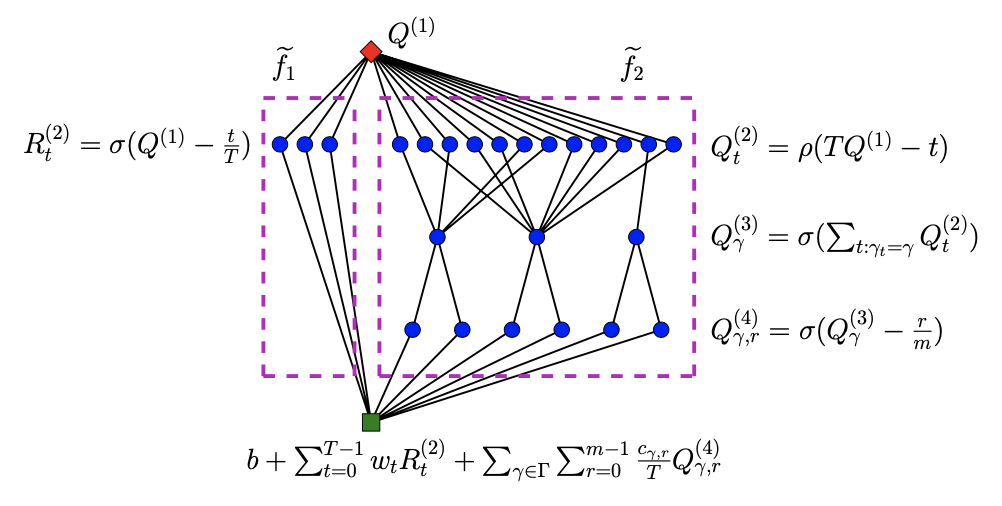

### Complexity of the optimal architecture



We can easily deduce from the description above, a complexity of $C_{T, m} = \mathcal{O}\big(T + m |\Gamma_m|\big)$ for this architecture. Now we would like to see $T = T(\varepsilon)$ and $m = m(\varepsilon)$ as functions in terms of error of approximation $\varepsilon$ such that the approximation $\tilde f_{T, m}$ built with the hyper-parameters $T(\varepsilon)$ and $m(\varepsilon)$ verifies:
$$\sup_{x \in [0, 1]} |f(x) - \tilde f_{T, m}(x)| \leq \varepsilon$$

Then, we would like to control the asymptotic behavior of $T(\varepsilon)$ and $m(\varepsilon)$ to control the complexity $C_{T, m} = C_\varepsilon$.

##### I - Upper bound from the article

If we take:
- $m(\epsilon) = \left\lceil \frac{1}{2} \log_3(1/\varepsilon) \right\rceil$
- $T(\varepsilon) = \left\lceil \frac{2}{m \varepsilon} \right\rceil$

then $\sup_{x \in [0, 1]} |f(x) - \tilde f_{T, m}(x)| \leq \varepsilon$ and $C_\varepsilon = \mathcal{O}\left(\frac{1}{\varepsilon \log(1/\epsilon)}\right)$


__proof (2)__

_The approximation error_

$$
\frac{2}{m \varepsilon} \leq T \leq \frac{2}{m \varepsilon} + 1 \ \ \ \ \ \text{(eq.1)}\\
\frac{1}{\varepsilon} \leq \frac{m T}{2} \leq \frac{1}{\varepsilon} + \frac{1}{2} \\
\varepsilon \geq \frac{2}{m T} \geq \frac{1}{\frac{1}{\varepsilon} + \frac{1}{2}} \geq  \frac{\varepsilon}{2} \ \text{as we consider} \ \varepsilon \leq \frac{1}{2}
$$

As we saw earlier, $\sup_{x \in [0, 1]} |f(x) - \tilde f_{T, m}(x)| \leq \frac{2}{m T}$, hence the first result about the error bound.

Note: We also have shown that $\frac{2}{m T} \geq \frac{\varepsilon}{2}$. So we can expect a real error of the approximation not too far from the bound $\varepsilon$ we wanted to ensure. Each is good otherwise, it would mean that a much less complex approximation would have been enough.

_The upper bound for the approximation complexity_

First, we determine the asymptotic behavior of $T(\varepsilon)$.

$$\frac{1}{2} \log_3\left(\frac{1}{\varepsilon}\right) \leq m \leq \frac{1}{2} \log_3\left(\frac{1}{\varepsilon}\right) + 1\\
\frac{2}{\log_3(1/\varepsilon)} \geq \frac{1}{m} \geq \frac{1}{\frac{1}{2}\log_3(1/\varepsilon) + 1} \geq \frac{\tau}{\log_3(1/\varepsilon)} \ \text{with} \ \tau = \left(\frac{1}{2} + \frac{1}{\log_3 2}\right)^{-1} \\
\frac{2 \tau}{\varepsilon \log_3(1/\varepsilon)} \leq \frac{2}{m \varepsilon} \leq \frac{4}{\varepsilon \log_3(1/\varepsilon)} \\
\frac{2 \tau}{\varepsilon \log_3(1/\varepsilon)} \leq T \leq \frac{4}{\varepsilon \log_3(1/\varepsilon)} + 1  \ \ \ \ \ \text{thanks to (eq.1)}
$$

This gives us: $T(\varepsilon) = \Theta\left(\frac{1}{\varepsilon \log(1/\varepsilon)}\right)$. Now we determine the asymptotic behavior of $m |\Gamma_m|$. We will use the upper bound $|\Gamma_m| \leq 3^m$ used in the article (we will see later that this can be improved a bit). This bound can easily be found by considering every element of $\Gamma_m$ as a path from 0 to 1 with $m$ segments with a maximum of 3 choices for each segment. So, let's find an upper bound for $m 3^m$!

$$3^{\frac{1}{2} \log_3 \frac{1}{\varepsilon}} \leq 3^m \leq 3 \ 3^{\frac{1}{2} \log_3 \frac{1}{\varepsilon}} \\
\left(\frac{1}{\varepsilon}\right)^{1/2} \leq 3^m \leq 3 \ \left(\frac{1}{\varepsilon}\right)^{1/2} \\
\frac{1}{2 \sqrt{\varepsilon}} \log_3\left(\frac{1}{\varepsilon}\right) \leq m 3^m \leq \frac{3}{2 \sqrt{\varepsilon}} \log_3\left(\frac{1}{\varepsilon}\right) + \frac{3}{\sqrt{\varepsilon}}$$

Which gives $m 3^m = \Theta\left(\frac{1}{\sqrt{\varepsilon}} \log_3\left(\frac{1}{\varepsilon}\right)\right) \ \Longrightarrow m |\Gamma_m| = \mathcal{O} \left(\frac{1}{\sqrt{\varepsilon}} \log_3\left(\frac{1}{\varepsilon}\right)\right) = \mathcal{o}\big(T(\varepsilon)\big)$

In the end, we get $C_\varepsilon = \mathcal{O}\big(T(\varepsilon)\big) = \mathcal{O}\left(\frac{1}{\varepsilon \log(1/\varepsilon)}\right)$

__end__

##### II - Possible improvements

Now we will discuss the possible improvements for the upper bound of $C_\epsilon$. There are two axes:

1. The asymptotic behavior of $|\Gamma_m|$

To establish the upper bound $C_\varepsilon = \mathcal{O}\left(\frac{1}{\varepsilon \log(1/\varepsilon)}\right)$ we used the fact that $|\Gamma_m| \leq 3^m$, but it can be improved a little bit. With some combinatorics, we can find an explicit expression for $|\Gamma_m|$, seeing $|\Gamma_m|$ as the number of paths starting at (0,0), ending at (m,0) and at each step you have 3 possible choices: _up step_ , _flat step_ , _down step_.

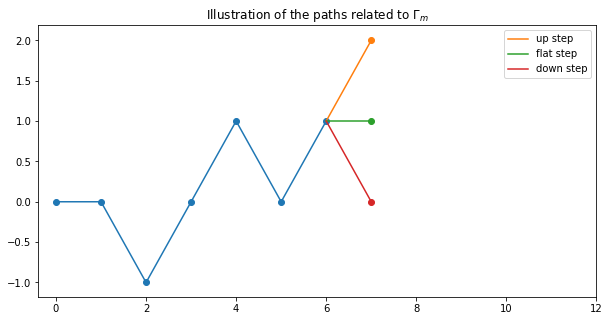

- Let's consider $m = 2 n$

So the number of *flat steps* is even. We can count the number of paths with $r = 2k$ *flat steps*: there are $\binom{2 n}{2k}$ possible combinations for the *flat steps*, $\binom{2n - 2k}{n - k}$ possible combinations for the *up steps*, it leaves one possibility for the *down steps*. We can deduce the expression:

$$
|\Gamma_{2n}| = \sum_{k=0}^{n} \binom{2 n}{2 k} \binom{2n - 2k}{n - k} \\
|\Gamma_{2n}| = \sum_{k=0}^{n} \binom{2 n}{2 k} \binom{2k}{k} \ \ \ \ \ k \leftarrow n - k
$$

- Let's consider $m = 2 n+1$

So the number of *flat steps* is odd. We can count the number of paths with $r = 2k+1$ *flat steps*: there are $\binom{2 n+1}{2k+1}$ possible combinations for the *flat steps*, $\binom{2n - 2k}{n - k}$ possible combinations for the *up steps*, it leaves one possibility for the *down steps*. We can deduce the expression:

$$
|\Gamma_{2n+1}| = \sum_{k=0}^{n} \binom{2 n+1}{2 k} \binom{2n - 2k}{n - k} \\
|\Gamma_{2n+1}| = \sum_{k=0}^{n} \binom{2 n+1}{2 k} \binom{2k}{k} \ \ \ \ \ k \leftarrow n - k
$$

- General formula $m \in \mathbb{N}$

$$|\Gamma_m| = \sum_{k=0}^{\lfloor m \ / \ 2 \rfloor} \binom{m}{2 k} \binom{2k}{k}$$

However, it seems there is no simple expression that does not involve a sum of binomials (we've tried, then looked in the scientific literature, unfortunately in this order). Nevertheless, $\Gamma_m$ is deeply linked with well-studied numbers: the Motzkin numbers $(M_m)$, which can also be seen as the counting of the same paths but without crossing the x-axis. Thus, we could have found in the scientific literature (Analytic Combinatorics, Philippe Flajolet & Robert Sedgewick, Cambridge University, 2009, p.396) a proof for the asymptotic behavior of $|\Gamma_m|$ by studying the generating function of $\big(|\Gamma_m|\big)_{m \in \mathbb{N}}$:

$$|\Gamma_m| \sim \frac{m}{3} M_m \sim \frac{1}{2}\sqrt{\frac{3}{\pi}} \frac{3^m}{\sqrt m}$$

This result is observed numerically.

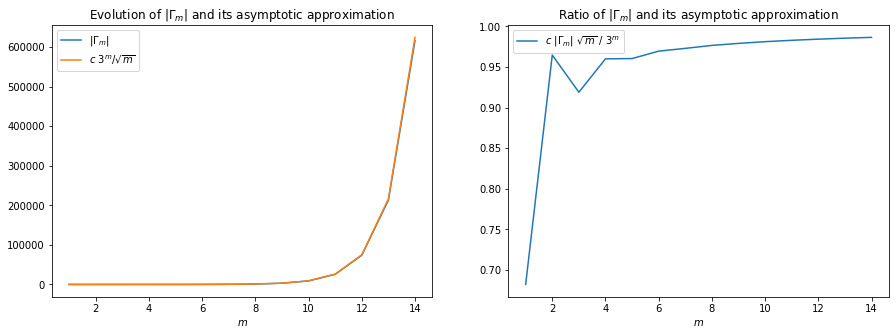

Thus, we can deduce this slightly better upper bound $C_{T, m} = \mathcal{O}\left(T + \sqrt{m} \ 3^m\right)$.

2. Balance between $T(\varepsilon)$ and $m(\varepsilon)$

In the previous proof (2) about the upper bound $C_\varepsilon = \mathcal{O}\left(\frac{1}{\varepsilon \log(1/\varepsilon)}\right)$ we saw that $m(\varepsilon) \ |\Gamma_{m(\varepsilon)}| = \mathcal{o}\big(T(\varepsilon)\big)$ where:
- $m(\epsilon) = \left\lceil \frac{1}{2} \log_3(1/\varepsilon) \right\rceil$
- $T(\varepsilon) = \left\lceil \frac{2}{m(\varepsilon) \ \varepsilon} \right\rceil$

Therefore, $m(\varepsilon) \ |\Gamma_{m(\varepsilon)}|$ didn't count for the asymptotic upper bound of $C_\varepsilon = \mathcal{O}\left(T(\varepsilon) + m(\varepsilon) \ |\Gamma_{m(\varepsilon)}| \right)$. An optimal choice for the expressions of $m(\varepsilon)$ and $T(\varepsilon)$ would allow both terms $T(\varepsilon)$ and $m(\varepsilon) \ |\Gamma_{m(\varepsilon)}|$ to be equally significant. So, we could expect that there exists a slightly bigger $m(\varepsilon)$ and a slightly smaller $T(\varepsilon)$ such that $T(\varepsilon) = \omicron\left(\frac{1}{\varepsilon \log(1/\varepsilon)}\right)$ and $\sqrt{m} \ 3^m = \omicron\left(\frac{1}{\varepsilon \log(1/\varepsilon)}\right)$. Unfortunately, it is not possible.

**The upper bound $C_\varepsilon = \mathcal{O}\left(\frac{1}{\varepsilon \log(1/\varepsilon)}\right)$ cannot be improved**

__proof (3)__

We introduce the variable $x = \frac{1}{\varepsilon}$

Let $a \in \mathbb{R}$. We take $m(x) = \lceil a \ \log_3x \rceil$

We have $\sup_{x \in [0, 1]} |f(x) - \tilde f_{T, m}(x)| \leq \frac{2}{T m}$. More precisely, this upper bound is optimal as it can be achieved for some 1-Lipschitz functions. So it is imperative that $\frac{2}{T m} \leq \varepsilon \Longleftrightarrow T \geq \frac{2  x}{m}$. 

Therefore, the smallest valid $T$ is $\left\lceil \frac{2 x}{m(x)} \right\rceil$ (up to a factor +1). That gives $T(x) = \Theta\left( \frac{x}{\log x} \right)$, the parameter $a$ doesn't change anything for the asymptotic behavior of $T(x)$.

Let's take a look at $\sqrt{m(x)} \ 3^{m(x)}$.

$$
a \ \log_3 x \leq m(x) \leq a \ \log_3 x + 1 \\
3^{a \ \log_3 x} \leq  3^{m(x)} \leq 3 \ 3^{a \ \log_3 x} \\
x^a \leq 3^{m(x)} \leq 3 \ x^a
$$

Thus, $\sqrt{m(x)} \ 3^{m(x)} = \Theta\left( \sqrt{\log x} \ x^a \right)$. We notice that :
- $a \geq 1 \ \Longrightarrow \ T(x) = \omicron\big( \sqrt{m(x)} \ 3^{m(x)} \big)$ 
- $a < 1 \ \Longrightarrow \ \sqrt{m(x)} \ 3^{m(x)} = \omicron\big( T(x) \big)$ 

Moreover, regardless of the expression of $m(x)$, $\left\lceil \frac{2 x}{m(x)} \right\rceil$ will always be the smallest valid $T(x)$. Therefore, the only chance to beat the upper bound $T + \sqrt{m} \ 3^m = \mathcal{O}\left( \frac{x}{\log x} \right)$ is to take $m(x)$ asymptotically bigger than $\log x$. But we've just seen that changing the factor in front of $\log_3 x$ is enough to make the asymptotic behavior of $\sqrt{m(x)} \ 3^{m(x)}$ explode. 

Besides, the upper bound $C_{T, m} = \mathcal{O}\left(T + \sqrt{m} \ 3^m\right)$ is optimal because it can be achieved. Indeed, we have seen that $m|\Gamma_m| \ \sim \ \sqrt{m} \ 3^m$. Also, we have just seen that $T(x)$ will always be greater than $m(x)$ (asymptotically) so all the elements of $\Gamma_m$ could be used during the construction of the approximation. It could and it certainly can, such a 1-Lipschitz function can easily be built for this purpose.

To conclude, the upper bound $C_x = \mathcal{O}\left( \frac{x}{\log x} \right)$ is optimal for this kind of neural network architecture.

__end__

### Implementation of the optimal architecture in python

First, we need a function that generates $\Gamma_m$.

In [13]:
# Recursive function which generates Gamma_m
# Input: hyper-parameter m
# Output: |Gamma_m| x (m+1) matrix :
#               each row corresponds to an element of Gamma_m
#               each column corresponds to the values taken by the elements at a breakpoint 


# Recursive scheme:
#
# At the step r we have: prev = [e1, e2, ..., er] (example of one ei : [0, -1, 0, 1, 2, 2])
#
# We denote by l(ei) the last value in ei (in the example above l(ei) = 2)
# For each element of prev we make the transformation: ei <- [ei, l(ei) - 1], [ei, l(ei)], [ei, l(ei) + 1]
# 
# This ends when every element has a length of m+1. We finally multiply all the values by 2/m.

# Note that we first calculate the elements of Gamma_m using -1, 0 and 1 and not directly with -2/m, 0, and 2/m.
# Because it is more stable (in terms of numerical approximation of rationals).

def Gamma_gen(m, prev = [[0]]):
    n = len(prev[0])
    curr = []
    
    if n < m:
        for gamma in prev:
            # if for some x, |gamma(x)| >= 1 (m/2 in this implementation) then it can't be equal to 0 at x=1
            if abs(gamma[-1]) <= m/2:
                for delta in [-1, 0, 1]:
                    curr.append(gamma + [gamma[-1]+delta])
        return Gamma_gen(m, curr)
    
    else:
        for gamma in prev:
            # The second to last value has to be between -2/m and 2/m (-1 and 1 in this implementation)
            # to have a last value of 0
            if abs(gamma[-1]) <= 1:
                curr.append(gamma + [0])
        return 2/m*np.array(curr)
    

In [14]:
# Let's see if it works

print(Gamma_gen(4))

[[ 0.  -0.5 -1.  -0.5  0. ]
 [ 0.  -0.5 -0.5 -0.5  0. ]
 [ 0.  -0.5 -0.5  0.   0. ]
 [ 0.  -0.5  0.  -0.5  0. ]
 [ 0.  -0.5  0.   0.   0. ]
 [ 0.  -0.5  0.   0.5  0. ]
 [ 0.   0.  -0.5 -0.5  0. ]
 [ 0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.  -0.5  0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.5  0.   0. ]
 [ 0.   0.   0.5  0.5  0. ]
 [ 0.   0.5  0.  -0.5  0. ]
 [ 0.   0.5  0.   0.   0. ]
 [ 0.   0.5  0.   0.5  0. ]
 [ 0.   0.5  0.5  0.   0. ]
 [ 0.   0.5  0.5  0.5  0. ]
 [ 0.   0.5  1.   0.5  0. ]]


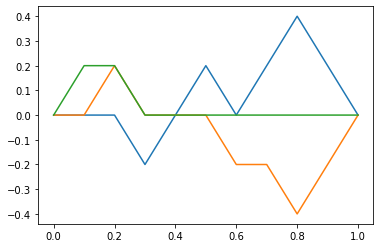

In [15]:
# Plot the curve of some gammas function

m = 10

x = np.linspace(0, 1, m+1)
Gamma = Gamma_gen(m)
subGamma = Gamma[np.random.randint(0, len(Gamma), 3)]

for gamma in subGamma:
    plt.plot(x, gamma)


plt.show()

We now have all the necessary tools to implement the optimal architecture. We don't need the function `Gamma_gen` thanks to an optimization in the implementation but it was useful to verify the asymptotic behavior of $|\Gamma_m|$

In [16]:
# Optimal implementation of the approximation as a neural network

# Inputs : target function f
#          hyper-parameter T
#          hyper-parameter m
#
# Output : ftilde as a neural network

def adaptive_network(f, T, m):
    
    # First layer - the input
    x = Input(shape=(1,), name="x")
    
    # - - - - - - - - - - - - - - - - - - - - - -
    # - - - piece-wise linear interpolation - - -
    # - - - - - - - - - - - - - - - - - - - - - -
    
    points = np.arange(T+1)/T
    values = f(points)
    f1tilde = piecewise_linear(points, values, x, "interpolation")
    
    # - - - - - - - - - - - - - -
    # - - - residu function - - -
    # - - - - - - - - - - - - - -
    
    
    
    #
    # - - - Second layer : rho(T x - t) - - -
    #
    
    Q2 = []
    for t in range(T):
        Q2.append(Dense(units = 1, 
                        activation = rho_activation,
                        kernel_initializer = Constant(T), 
                        bias_initializer = Constant(-t),
                        name = "Q2_"+str(t))(x))
    
    
    
    #
    # - - - Third layer : sum_{0 <= t < T | gamma_t = gamma} Q2_t - - -
    #

    
    # - Build (gamma_t)_{0 <= t < T} -
    
    # auxiliary function g_t
    model_f1tilde = Model(x, f1tilde)
    def g(t, y):
        X = (t+y)/T
        return T*(f(X) - model_f1tilde.predict(np.array([X])).flatten()[0])
    
    # Computation
    gamma_t_values = np.zeros((T, m+1))
    for t in range(T):
        for r in range(m+1):
            if r == 0 or r == m:
                gamma_t_values[t][r] = 0
            else:
                gamma_t_values[t][r] = 2/m * np.rint(g(t, r/m)/(2/m))
    
    # - Build the layer -
    
    # We will sum over the used gamma in Gamma_m
    used_gamma, index_gamma = np.unique(gamma_t_values, return_inverse=True, axis=0)
    
    Q3 = [[] for gamma in used_gamma]
    SizeQ3 = len(Q3)
    
    # gather the identical gamma_t
    for t in range(T):
        Q3[index_gamma[t]].append(Q2[t])
    
    # sum over the used gamma in Gamma_m
    for i in range(SizeQ3):
        SizeQ3i = len(Q3[i])
        if SizeQ3i >= 2:
            Q3[i] = concatenate(Q3[i])
            Q3[i] = Dense(units = 1, 
                          activation = rho_activation,
                          kernel_initializer = ones(), 
                          bias_initializer = zeros(),
                          name = "Q3_"+str(i))(Q3[i])
        else:
            Q3[i] = Dense(units = 1,
                          activation = rho_activation,
                          kernel_initializer = ones(), 
                          bias_initializer = zeros(),
                          name = "Q3_"+str(i))(Q3[i][0])
    
    
    
    #
    # - - - Fourth layer : rho(Q3 - r/m) - - -
    #
    
    Q4 = []
    
    for i in range(SizeQ3):
        Q4.append(Dense(units = m,
                        activation = relu,
                        kernel_initializer = ones(), 
                        bias_initializer = Constant(-np.arange(m)/m),
                        name = "Q4_"+str(i))(Q3[i]))
    
    
    
    #
    # - - - Fifth layer : f2tilde(x) - - -
    #
    
    points = np.arange(m+1)/m
    w_gamma_r = np.zeros(m*SizeQ3)
    for i in range(SizeQ3):
        w_gamma_r[i*m:(i+1)*m] = weights_piecewise_linear(points, used_gamma[i])
    
    
    Q5 = Q4[0]
    if len(Q4) > 1:
        Q5 = concatenate(Q4)
    Q5 = Dense(units = 1, 
               activation = linear, 
               bias_initializer = zeros(), 
               kernel_initializer = Constant(w_gamma_r/T),
               name = "Q5")(Q5)
    
    
    
    # - - - - - - - - - - - - - -
    # - - - merged model - - -
    # - - - - - - - - - - - - - -
    
    ftilde = concatenate([Q5] + [f1tilde])
    ftilde = Dense(units = 1, 
                   activation = linear, 
                   kernel_initializer = ones(), 
                   name = "ftilde")(ftilde)
    
    return Model(x, ftilde)
        
        

m = 4
T = 10
size_opt = 104
size_naive = 193


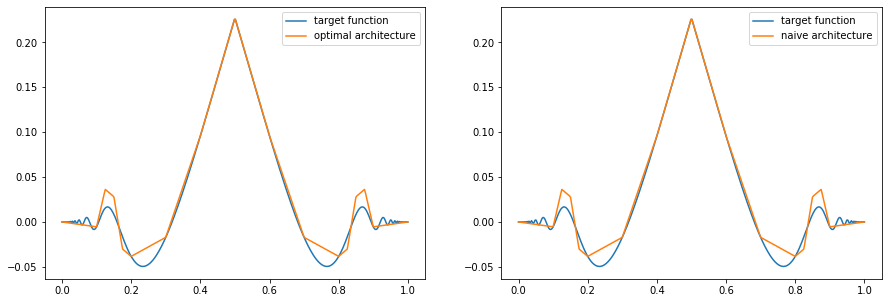

In [17]:
# Let's test the algorithm

# Define the hyper-parameters
m = 4
T = 10
print("m =", m)
print("T =", T)

# Create the corresponding neural network - with the two algorithm
f_opt = adaptive_network(target, T, m)
f_naive = adaptive_network_naive(target, T, m)
print("size_opt =", f_opt.count_params())
print("size_naive =", f_naive.count_params())


# Plot the graph of the target function and the approximation

x = np.linspace(0, 1, 400)
y_opt = f_opt.predict(x)
y_naive = f_naive.predict(x)

figure = plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, target(x), label="target function")
plt.plot(x, y_opt, label="optimal architecture")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, target(x), label="target function")
plt.plot(x, y_naive, label="naive architecture")
plt.legend()

plt.show()

As expected, the approximations are perfectly similar and the naive architecture has a greater complexity than the optimal one.

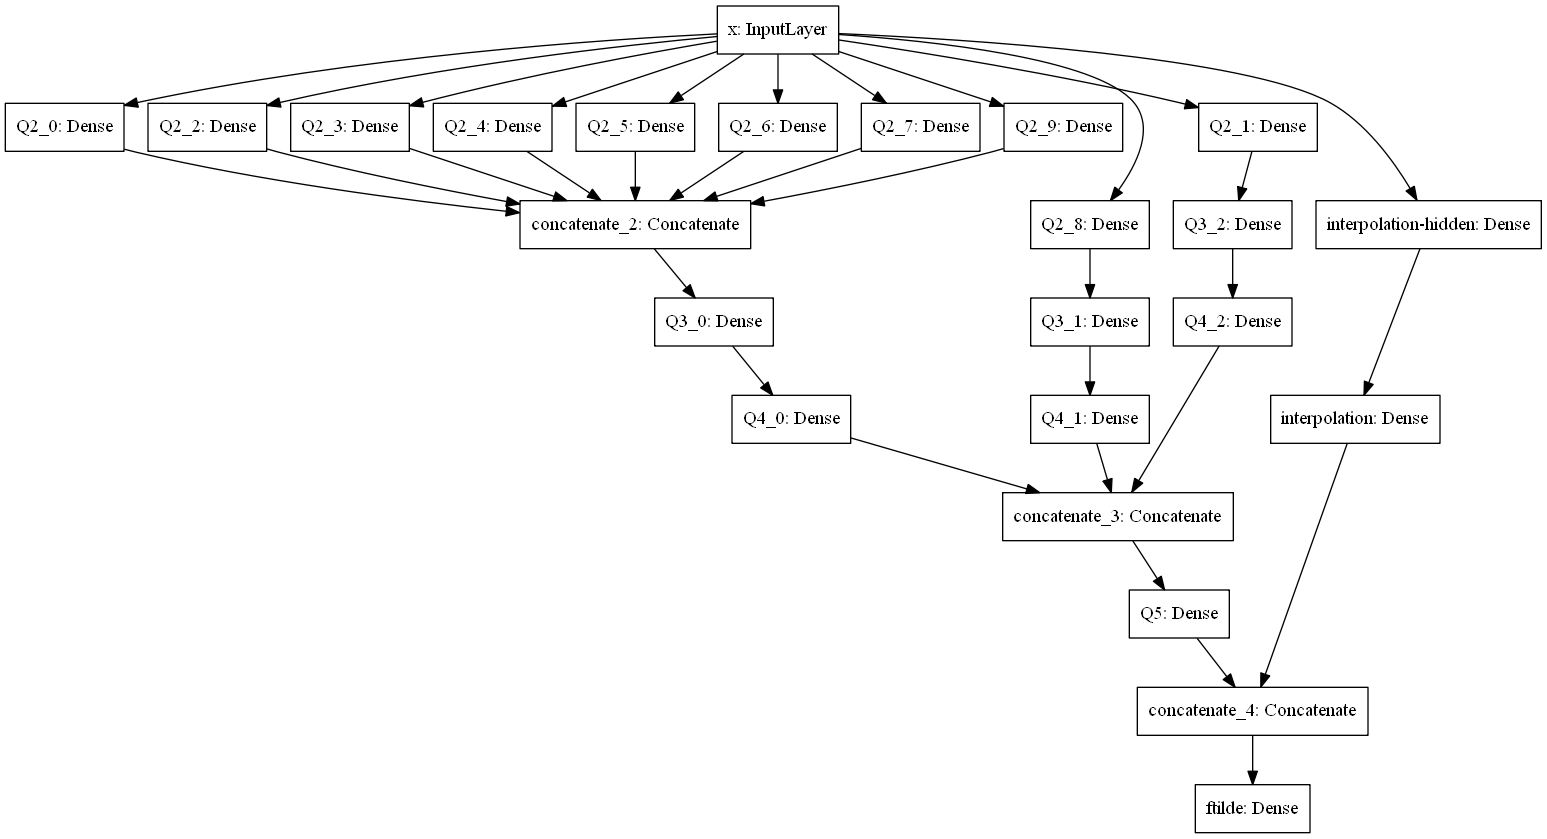

In [18]:
# Visualize the model

plot_model(f_opt, to_file='model_opt.png')


This model illustrates well why this architecture is so efficient. We can see in the second layer (Q2) that the same element from $\Gamma_m$ has been used several times. Here, the neural network uses only 3 elements from $\Gamma_m$. In the naive architecture, it uses every time $T$ elements from $\Gamma_m$ with a high probability of redundancy (it is the case here).

Now, let's see the evolution of some values related to this neural network using $m(\varepsilon)$ and $T(\varepsilon)$ from the article.

In [19]:
# Comparison with

epsGrid = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001]

# m(eps) and T(eps) 
ms = []
Ts = []

# C(eps)
Cs_art = []

# Setting variables to estimate the error of approximation
xtest = np.random.uniform(0, 1, 10000)
ytest = target(xtest)
errs_art = []

# Going through the grid of values
for eps in epsGrid:
    # Set the hyper-parameters
    m = int(np.ceil(0.5*np.log(1/eps)/np.log(3)))
    T = int(np.ceil(2/m/eps))
    
    # Build the model
    ftilde = adaptive_network(target, T, m)
    
    # Get the size
    C = ftilde.count_params()
    
    # Get the error
    err = np.mean(np.abs(ytest - ftilde.predict(xtest).flatten()))
    
    # Update the variables
    Cs_art.append(C)
    errs_art.append(err)
    ms.append(m)
    Ts.append(T)
    
    # Show the computation
    print("eps =", eps, " | m =", m, " | T =", T, " | C =", C, " | err =", err)
    
# To free some RAM
ftilde = adaptive_network(target, 10, 3)

eps = 0.5  | m = 1  | T = 4  | C = 33  | err = 0.0163689808692554
eps = 0.2  | m = 1  | T = 10  | C = 69  | err = 0.007614436745011921
eps = 0.1  | m = 2  | T = 10  | C = 72  | err = 0.007614436745011921
eps = 0.05  | m = 2  | T = 20  | C = 132  | err = 0.002197343677088158
eps = 0.02  | m = 2  | T = 50  | C = 312  | err = 0.0006584878030789395
eps = 0.01  | m = 3  | T = 67  | C = 427  | err = 0.0003899651608962242
eps = 0.005  | m = 3  | T = 134  | C = 819  | err = 0.00015321141781258346
eps = 0.002  | m = 3  | T = 334  | C = 2019  | err = 4.0440872240940776e-05
eps = 0.001  | m = 4  | T = 500  | C = 3018  | err = 2.1105819977003308e-05
eps = 0.0005  | m = 4  | T = 1000  | C = 6057  | err = 7.367931208219611e-06
eps = 0.0002  | m = 4  | T = 2500  | C = 15057  | err = 2.1379787800055013e-06
eps = 0.0001  | m = 5  | T = 4000  | C = 24181  | err = 1.3420729239950174e-06


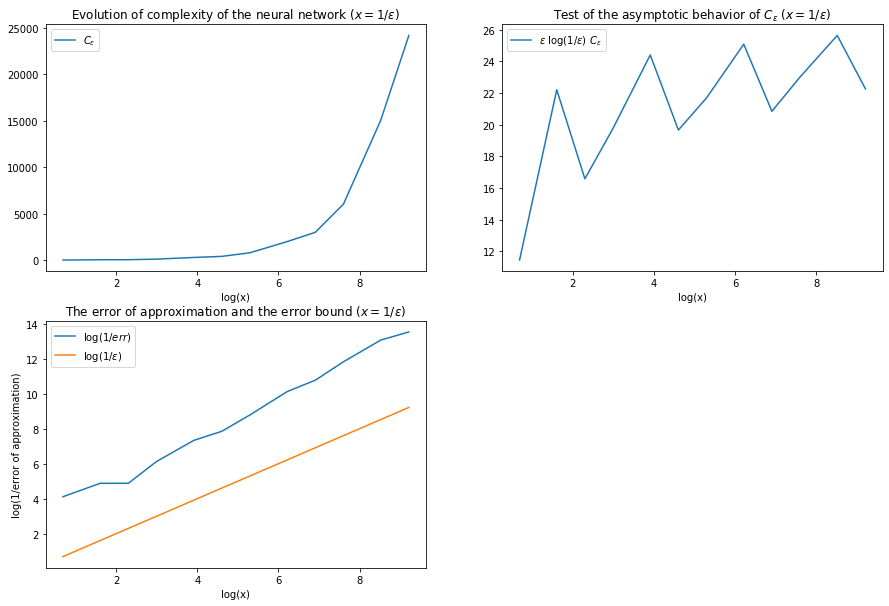

In [20]:
# - - - Reformating the variables to numpy arrays - - -

epsGrid = np.array(epsGrid)
ms = np.array(ms)
Ts = np.array(Ts)
Cs_art = np.array(Cs_art)
errs_art = np.array(errs_art)


# - - - Visualising the results - - -

figure = plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.plot(np.log(1/epsGrid), Cs_art, label = "$C_\epsilon$")
plt.xlabel("log(x)")
plt.title("Evolution of complexity of the neural network ($x = 1/\epsilon$)")
plt.legend()


plt.subplot(2,2,2)
plt.plot(np.log(1/epsGrid), Cs_art * epsGrid * np.log(1/epsGrid), label="$\epsilon \ \log(1/\epsilon) \ C_{\epsilon}$")
plt.xlabel("log(x)")
plt.title("Test of the asymptotic behavior of $C_\epsilon$ ($x = 1/\epsilon$)")
plt.legend()


plt.subplot(2,2,3)
plt.plot(np.log(1/epsGrid), np.log(1/errs_art), label="$\log(1/err)$")
plt.plot(np.log(1/epsGrid), np.log(1/epsGrid), label="$\log(1/\epsilon)$")
plt.xlabel("log(x)")
plt.ylabel("log(1/error of approximation)")
plt.title("The error of approximation and the error bound ($x = 1/\epsilon$)")
plt.legend()


plt.show()

It seems that $\varepsilon \ \log(1/\varepsilon) \ C_\varepsilon$ converges to a constant, as expected. Also, $\log\left(\frac{1}{\eta}\right) \geq \log\left(\frac{1}{\varepsilon}\right)$ with $\eta$ the error of approximation. More precisely, it seems that $\log\left(\frac{1}{\eta}\right) = \alpha \ \log\left(\frac{1}{\varepsilon}\right) + \beta$. We can do a linear regression to analyse the behavior more carefully.

alpha = 1.1733436246429432
beta = 2.7482615815702003


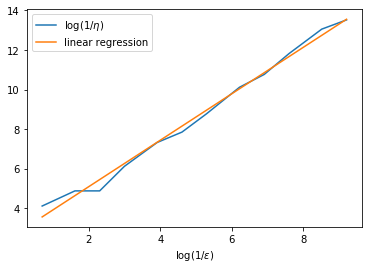

In [21]:
x = np.log(1/epsGrid)
y = np.log(1/errs_art)

alpha = np.sum((x - np.mean(x))*(y - np.mean(y)))/np.sum((x - np.mean(x))**2)
beta = np.mean(y) - alpha * np.mean(x)

print("alpha =", alpha)
print("beta =", beta)

plt.plot(x, y, label="$\log(1/\eta)$")
plt.plot(x, beta + alpha*x, label="linear regression")
plt.legend()
plt.xlabel("$\log(1/\epsilon)$")
plt.show()

$$
\log\left(\frac{1}{\eta}\right) = \alpha \ \log\left(\frac{1}{\varepsilon}\right) + \beta \\
\frac{1}{\eta} = e^\beta \ \left(\frac{1}{\varepsilon}\right)^\alpha \\
\eta = e^{-\beta} \ \varepsilon^\alpha
$$

As $\alpha$ is close to $1$, the error of approximation is close to being of the same magnitude of $\varepsilon$, Which is what was suspected ( _note in proof (2)_ ). Now, let's compare these results with different combinations of $m$ and $T$.

In [22]:
# Set the combinations of m and T tested
mGrid = 3*np.arange(6) + np.ones(6).astype(int)
TGrid = np.floor(1.5**np.arange(1, 15)).astype(int)

# Setting variables to estimate the error of approximation 
xtest = np.random.uniform(0, 1, 10000)
ytest = target(xtest)

# Initialize variables
errs = np.zeros((len(mGrid), len(TGrid)))
Cs = np.zeros((len(mGrid), len(TGrid)))

for i in range(len(mGrid)):
    m = mGrid[i]
    
    print("m =", m, "| T = ", end="")
    for j in range(len(TGrid)):
        T = TGrid[j]
        
        # Build the corresponding approximation
        ftilde = adaptive_network(target, T, m)
        
        # Get the complexity and the error of approximation
        Cs[i][j] = ftilde.count_params()
        errs[i][j] = np.mean(np.abs(ytest - ftilde.predict(xtest).flatten()))
        
        print(T, end=" ")
        
    print()

m = 1 | T = 1 2 3 5 7 11 17 25 38 57 86 129 194 291 
m = 4 | T = 1 2 3 5 7 11 17 25 38 57 86 129 194 291 
m = 7 | T = 1 2 3 5 7 11 17 25 38 57 86 129 194 291 
m = 10 | T = 1 2 3 5 7 11 17 25 38 57 86 129 194 291 
m = 13 | T = 1 2 3 5 7 11 17 25 38 57 86 129 194 291 
m = 16 | T = 1 2 3 5 7 11 17 25 38 57 86 129 194 291 


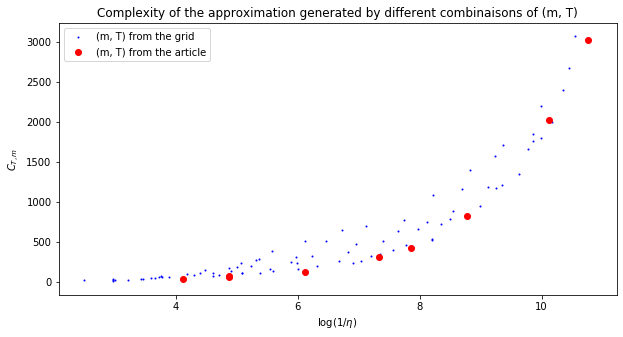

In [23]:
# Visualise the results

figure = plt.figure(figsize=(10, 5))

# The complexity for the different combinaisons of (m, T)
plt.scatter(np.log(1/errs[0]), Cs[0], s=1, c="b", label="(m, T) from the grid")
for i in range(1, len(mGrid)):
    plt.scatter(np.log(1/errs[i]), Cs[i], s=1, c="b")

# The complexity for (m, T) from the article
plt.scatter(np.log(1/errs_art[:-3]), Cs_art[:-3], c='r', label="(m, T) from the article")


plt.xlabel("$\log(1/\eta)$")
plt.ylabel("$C_{T, m}$")
plt.legend()
plt.title("Complexity of the approximation generated by different combinaisons of (m, T)")
plt.show()

We notice the dots corresponding to $(m, T)$ from the article are in the lower part of the set of points. Which illustrates that this choice is actually optimal.

### Other 1-Lipschitz target functions on $[0,1]$

For these last tests, we would like a function which is at the limit of not being 1-Lipschitz. Inspired by some fractals, we have defined the following function recursively:

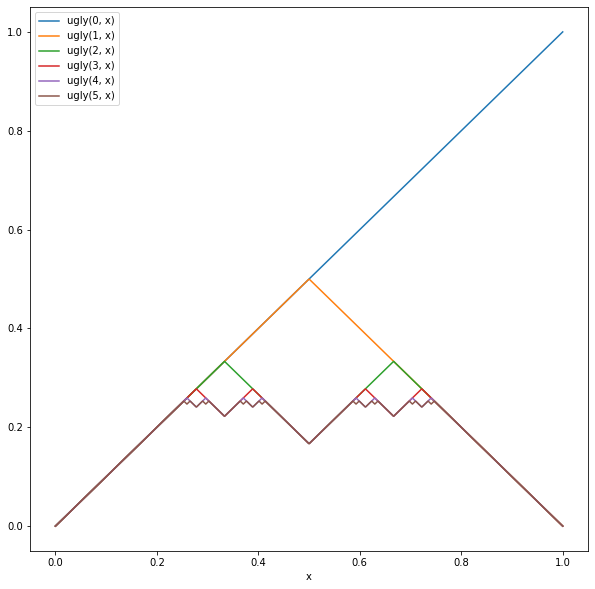

In [24]:
def cut(c, x):
    return (x <= c) * x + (x > c) * (2*c - x)

def u(n):
    return 3/4*(1/3)**n +1/4

def ugly(n, x):
    if n > 0:
        return cut(u(n), ugly(n-1, x))
    else:
        return x

figure = plt.figure(figsize=(10, 10))
x = np.linspace(0, 1, 1000)
for n in range(6):
    plt.plot(x, ugly(n, x), label="ugly("+str(n)+", x)")
plt.legend()
plt.xlabel("x")
plt.show()

Let's define other target functions :
- $f_0(x) = \frac13 \left(x \mathbf{1}_{x \leq \frac12} + (1-x) \mathbf{1}_{\frac12 < x}\right)$
- $f_1(x) = \text{ugly}(10, x)$
- $f_2(x) = x^2(1- \frac23 x)$
- $f_3(x) = \frac{1}{3 \pi}\sin(3 \pi x)$
- $f_4(x) = f_0(f_3(x))$

In [25]:
def f0(x):
    return (x*(x <= 1/2) + (1-x)*(1/2 < x))/3

def f1(x) :
    return ugly(10, x)

def f2(x) :
    return x**2*(1-2*x/3)

def f3(x) :
    return 1/(3*np.pi)*np.sin(3*np.pi*x)

def f4(x) :
    return f0(f3(x))

    

new_targets = np.array([["$f_1$", f1], 
                        ["$f_2$", f2],
                        ["$f_3$", f3],
                        ["$f_4$", f4]])

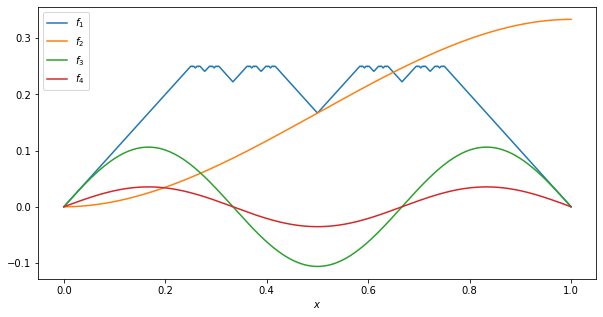

In [26]:
# Visualization 

i = 0
x = np.linspace(0, 1, 1000)

figure = plt.figure(figsize=(10, 5))

for tgt in new_targets :
    i += 1
    y = tgt[1](x)
    plt.plot(x, y, label=tgt[0])

plt.xlabel("$x$")
plt.legend()
plt.show()

In [27]:
epsGrid = 0.5**np.arange(1, 13)

# Setting variables in order to estimate the error of approximation 
xtest = np.random.uniform(0, 1, 10000)

# Intialize variables
etas = np.zeros((len(new_targets), len(epsGrid)))
Cs = np.zeros((len(new_targets), len(epsGrid)))

for i in range(len(new_targets)):
    # Set the i-th function
    f = new_targets[i][1]
    
    # Compute the test set to compute the error of approximation
    ytest = f(xtest)
    
    print(new_targets[i][0][1:-1], end=" | ")
    for j in range(len(epsGrid)):
        # Set m and T
        eps = epsGrid[j]
        m = int(np.ceil(0.5*np.log(1/eps)/np.log(3)))
        T = int(np.ceil(2/m/eps))
        
        # Build the corresponding approximation
        ftilde = adaptive_network(f, T, m)
        
        # Get the error of approximation and the complexity of the neural network
        eta = np.mean(np.abs(ytest - ftilde.predict(xtest).flatten()))
        C = ftilde.count_params()
        
        # Update the variables
        etas[i][j] = eta
        Cs[i][j] = C
        
        print(eps, end=" ")
        
    print()
    

f_1 | 0.5 0.25 0.125 0.0625 0.03125 0.015625 0.0078125 0.00390625 0.001953125 0.0009765625 0.00048828125 0.000244140625 
f_2 | 0.5 0.25 0.125 0.0625 0.03125 0.015625 0.0078125 0.00390625 0.001953125 0.0009765625 0.00048828125 0.000244140625 
f_3 | 0.5 0.25 0.125 0.0625 0.03125 0.015625 0.0078125 0.00390625 0.001953125 0.0009765625 0.00048828125 0.000244140625 
f_4 | 0.5 0.25 0.125 0.0625 0.03125 0.015625 0.0078125 0.00390625 0.001953125 0.0009765625 0.00048828125 0.000244140625 


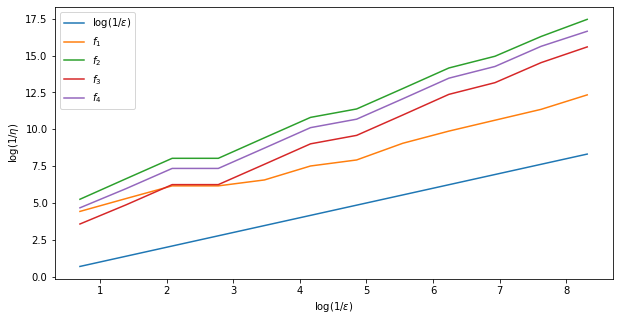

In [28]:
# Visualize the results

figure = plt.figure(figsize=(10, 5))

plt.plot(np.log(1/epsGrid), np.log(1/epsGrid), label="$\log(1/\epsilon)$")
for i in range(len(new_targets)):
    plt.plot(np.log(1/epsGrid), np.log(1/etas[i]), label=new_targets[i][0])

plt.legend()
plt.xlabel("$\log(1/\epsilon)$")
plt.ylabel("$\log(1/\eta)$")
plt.show()

We observe that for every function, $\frac{1}{\eta} \geq \frac{1}{\epsilon}$. Moreover, they seem to all (except $f_3$ which is to simple to approximate) follow the same trend as for the first target function we considered: 

$$\log\left(\frac{1}{\eta_i}\right) = \alpha_i \ \log\left(\frac{1}{\varepsilon}\right) + \beta_i \Longleftrightarrow
\eta_i = e^{-\beta_i} \ \varepsilon^{\alpha_i}
$$

Therefore, we can quantify how close the magnitude of $\eta_i$ are from $\varepsilon$ by calculating $\alpha_i$.

In [29]:
# Intialize the variable
alphas = np.zeros(len(new_targets))

# Compute alpha_i
for i in range(len(new_targets)):
    x = np.log(1/epsGrid)
    y = np.log(1/etas[i])

    alphas[i] = np.sum((x - np.mean(x))*(y - np.mean(y)))/np.sum((x - np.mean(x))**2)

# Print alpha_i
names = np.array(["alpha_"+str(i) for i in range(1, len(new_targets)+1)]).reshape(-1, 1)
print(np.concatenate((names, alphas.reshape(-1, 1)), axis=1))

[['alpha_1' '1.0043523171411126']
 ['alpha_2' '1.5681333612736585']
 ['alpha_3' '1.5571107938576663']
 ['alpha_4' '1.555453647389598']]


We can conclude the error of approximation $\eta_i$ decrease faster than the error of approximation of the original target function for $f_2, f_3 \ \text{and} \ f_4$. It illustrates the fact that these new target functions are easier to approximate. On the contrary, it seems that $\eta_1 \sim c \ \varepsilon$ which means that this function 
is one of the most difficult to approximate. It was expected as $f_1$ is really at the limit of not being a 1-Lipschitz function.

# Conclusion

We have illustrated the Theorem 2 from the article " _Error Bounds For approximations With Deep ReLU Networks_ ". We have implemented the neural network presented in the proof of this theorem and could have seen what was theoretically predicted. The astonishing upper bound of this theorem $C_\varepsilon = \mathcal{0}\left(\frac{1}{\varepsilon \log(1/\varepsilon)}\right)$ has been well illustrated here. Besides, we have able to refine a little bit the theorem by proving the optimality of this bound for the neural network architecture used in the proof of the theorem.

#### Authors

- Stephen JAUD
- Maéva CAILLOT
- Pierre-Jean POLLOT
- Gauthier PEZZOLI